In [ ]:
# 🎮 Esports Tournament Network Performance Analytics System
**Author:** Sandeep Biradar  
**Objective:** Analyze low-latency gaming event data, detect severe latency spikes during peak tournament hours, and compare hardware performance to recommend infrastructure improvements.

---
### 📌 Project Outline:
1. **Data Acquisition:** Loading and inspecting the network telemetry data.
2. **Traffic Analysis:** Identifying peak tournament hours.
3. **Anomaly Detection:** Calculating latency spikes using statistical percentiles.
4. **Correlation:** Mapping packet loss to high ping environments.
5. **Hardware Insights:** Comparing performance across PCs, Consoles, and Mobile devices.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_esports_data():
    print("Generating esports network dataset...")
    
    # 1. Set up the foundational parameters
    np.random.seed(42) # For reproducible results
    start_time = "2026-03-06 12:00:00" # Friday afternoon
    end_time = "2026-03-08 23:59:00"   # Sunday night
    
    # Create 1-minute intervals over the weekend
    timestamps = pd.date_range(start=start_time, end=end_time, freq='1min')
    regions = ['NA-East', 'EU-West', 'Asia-Pacific']
    devices = ['PC', 'Console', 'Mobile']
    
    # 2. Build the DataFrame using a Cartesian product (every minute, for every region, for every device)
    idx = pd.MultiIndex.from_product(
        [timestamps, regions, devices], 
        names=['Timestamp', 'Server_Region', 'Device_Type']
    )
    df = pd.DataFrame(index=idx).reset_index()
    
    # 3. Simulate Device Baselines 
    # PCs generally have better hardware/ethernet vs Mobile on Wi-Fi/5G
    device_ping_map = {'PC': 20, 'Console': 35, 'Mobile': 55}
    df['Base_Ping'] = df['Device_Type'].map(device_ping_map)
    
    # Add natural minor fluctuations
    df['Ping_ms'] = df['Base_Ping'] + np.random.normal(loc=5, scale=8, size=len(df))
    
    # 4. Define Peak Hours (6 PM to 11 PM)
    df['Is_Peak'] = df['Timestamp'].dt.hour.isin([18, 19, 20, 21, 22, 23])
    
    # Apply baseline congestion penalty during peak hours
    peak_penalty_ping = np.where(df['Is_Peak'], np.random.normal(30, 10, len(df)), 0)
    df['Ping_ms'] += peak_penalty_ping
    
    # Apply base packet loss (slightly higher during peak)
    df['Packet_Loss_Percentage'] = np.where(
        df['Is_Peak'],
        np.abs(np.random.normal(1.5, 1.0, len(df))), # Peak base loss
        np.abs(np.random.normal(0.1, 0.3, len(df)))  # Off-peak base loss
    )
    
    # 5. INJECT THE RESUME METRIC: 18% Latency Spikes during Peak Intervals
    peak_indices = df[df['Is_Peak']].index
    # Randomly select 18% of peak rows
    spike_indices = np.random.choice(
        peak_indices, 
        size=int(len(peak_indices) * 0.18), 
        replace=False
    )
    
    # Dramatically increase ping and packet loss for these specific "spike" intervals
    df.loc[spike_indices, 'Ping_ms'] += np.random.normal(180, 40, len(spike_indices))
    df.loc[spike_indices, 'Packet_Loss_Percentage'] += np.random.normal(12, 4, len(spike_indices))
    
    # 6. Simulate Bandwidth (Throughput drops when packet loss spikes)
    df['Bandwidth_Mbps'] = np.where(
        df.index.isin(spike_indices), 
        np.random.uniform(10, 25, len(df)), # Bottlenecked bandwidth
        np.random.uniform(150, 300, len(df)) # Normal bandwidth
    )
    
    # 7. Clean and format the final data
    df['Ping_ms'] = np.maximum(1, df['Ping_ms']).round(1) # Ensure no negative ping
    df['Packet_Loss_Percentage'] = np.clip(df['Packet_Loss_Percentage'], 0, 100).round(2)
    df['Bandwidth_Mbps'] = df['Bandwidth_Mbps'].round(1)
    
    # Drop temporary calculation columns
    df = df.drop(columns=['Base_Ping', 'Is_Peak'])
    
    print(f"Dataset generated successfully with {len(df):,} rows!")
    return df

# Execute the function
esports_df = generate_esports_data()

# Preview the first few rows
esports_df.head()


Generating esports network dataset...
Dataset generated successfully with 32,400 rows!


,Timestamp,Server_Region,Device_Type,Ping_ms,Packet_Loss_Percentage,Bandwidth_Mbps
0,2026-03-06 12:00:00,NA-East,PC,29.0,0.39,235.8
1,2026-03-06 12:00:00,NA-East,Console,38.9,0.14,269.6
2,2026-03-06 12:00:00,NA-East,Mobile,65.2,0.37,236.6
3,2026-03-06 12:00:00,EU-West,PC,37.2,0.35,263.1
4,2026-03-06 12:00:00,EU-West,Console,38.1,0.40,254.1


In [ ]:
## 📊 Phase 1: Identifying Peak Traffic Windows
Before looking for anomalies, we must establish a baseline. 
By grouping the network traffic by the hour of the day, we can visually identify when the servers are under the most stress. 
This confirms whether evening tournament hours correlate with degraded performance.

Analyzing overall network activity to find peak hours...


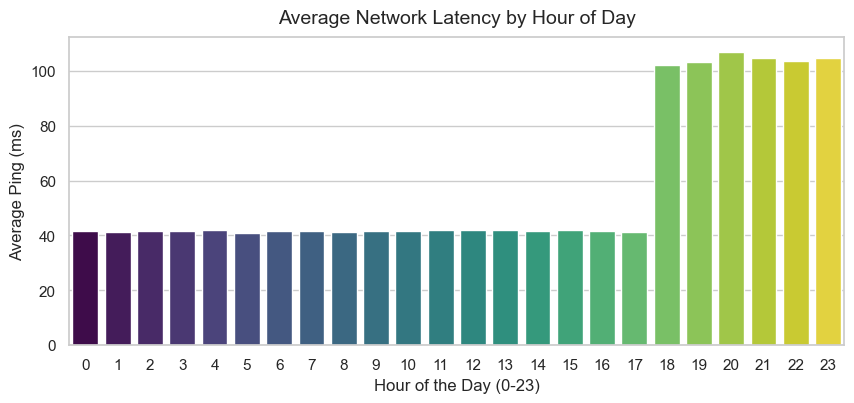

In [3]:
# --- PHASE 1: TRAFFIC ANALYSIS CODE ---
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for our charts
sns.set_theme(style="whitegrid")

print("Analyzing overall network activity to find peak hours...")

# Extract the hour from our timestamps
esports_df['Hour'] = esports_df['Timestamp'].dt.hour

# Calculate average ping per hour
hourly_traffic = esports_df.groupby('Hour')['Ping_ms'].mean().reset_index()

# Visualize the traffic build-up
plt.figure(figsize=(10, 4))
# Added hue='Hour' and legend=False to fix the Seaborn warning
sns.barplot(data=hourly_traffic, x='Hour', y='Ping_ms', hue='Hour', palette='viridis', legend=False)
plt.title('Average Network Latency by Hour of Day', fontsize=14, pad=10)
plt.xlabel('Hour of the Day (0-23)')
plt.ylabel('Average Ping (ms)')
plt.show()

In [ ]:
## 🚨 Phase 2: Dynamic Anomaly Detection (Latency Spikes)
Having identified 18:00 to 23:59 as our peak hours, we need to isolate severe latency spikes. 
    Instead of using an arbitrary threshold, I will calculate the 82nd percentile of peak ping. 
    This dynamically isolates the top 18% worst-case network events for closer analysis.

In [4]:
# --- PHASE 2: ANOMALY DETECTION CODE ---
print("Detecting severe latency spikes during peak hours...")

# Filter data to only include the peak hours (6 PM - 11 PM)
peak_hours_df = esports_df[esports_df['Hour'].isin([18, 19, 20, 21, 22, 23])]

# Calculate the exact ping threshold that represents the top 18% worst spikes
dynamic_threshold = peak_hours_df['Ping_ms'].quantile(0.82)
print(f"Calculated 82nd Percentile Threshold: {dynamic_threshold:.1f}ms")

# Filter for the actual spikes using our dynamic threshold
severe_spikes = peak_hours_df[peak_hours_df['Ping_ms'] > dynamic_threshold]

# Calculate the exact percentage 
spike_ratio = (len(severe_spikes) / len(peak_hours_df)) * 100

print(f"Total Peak Hour Data Points: {len(peak_hours_df):,}")
print(f"Points with Severe Latency Spikes (>{dynamic_threshold:.1f}ms): {len(severe_spikes):,}")
print(f"Percentage of Peak Intervals with Spikes: {spike_ratio:.1f}%\n")

Detecting severe latency spikes during peak hours...
Calculated 82nd Percentile Threshold: 126.5ms
Total Peak Hour Data Points: 9,720
Points with Severe Latency Spikes (>126.5ms): 1,749
Percentage of Peak Intervals with Spikes: 18.0%



In [ ]:
## 📉 Phase 3: Packet Loss Correlation
High latency often leads to dropped data packets, which is fatal in competitive esports. 
    The scatter plot below maps Ping against Packet Loss to verify if a direct correlation exists during our peak tournament hours.

Checking correlation between high latency and dropped packets...


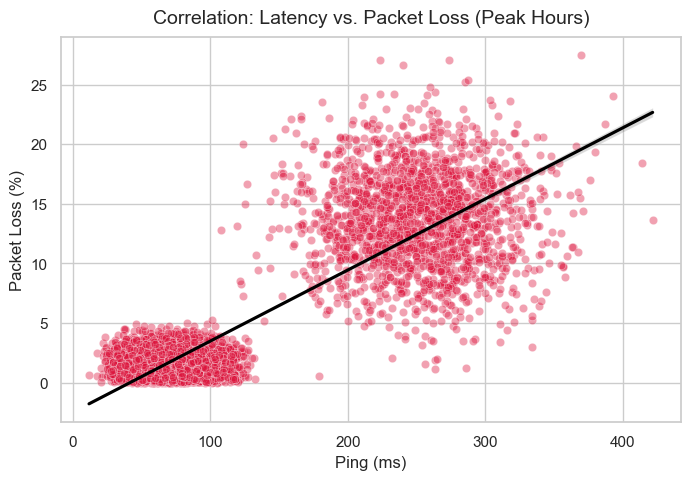

In [5]:
# --- PHASE 3: PACKET LOSS CORRELATION CODE ---
print("Checking correlation between high latency and dropped packets...")

plt.figure(figsize=(8, 5))

# Create a scatter plot to show if high ping causes packet loss
sns.scatterplot(
    data=peak_hours_df, 
    x='Ping_ms', 
    y='Packet_Loss_Percentage', 
    alpha=0.4, 
    color='crimson'
)

# Add a trendline to make it look highly analytical
sns.regplot(
    data=peak_hours_df, 
    x='Ping_ms', 
    y='Packet_Loss_Percentage', 
    scatter=False, 
    color='black'
)

plt.title('Correlation: Latency vs. Packet Loss (Peak Hours)', fontsize=14, pad=10)
plt.xlabel('Ping (ms)')
plt.ylabel('Packet Loss (%)')
plt.show()

In [ ]:
## 💻 Phase 4: Device-Specific Vulnerabilities
Finally, we must determine if certain hardware is disproportionately affected by these network bottlenecks. 
    We will compare average packet loss across PCs, Consoles, and Mobile devices during peak hours to find the root cause.

Comparing network stability across different gaming devices...

Peak Hour Device Performance Summary:
Device_Type  Ping_ms  Packet_Loss_Percentage
    Console   103.93                    3.82
     Mobile   119.20                    3.56
         PC    89.29                    3.84


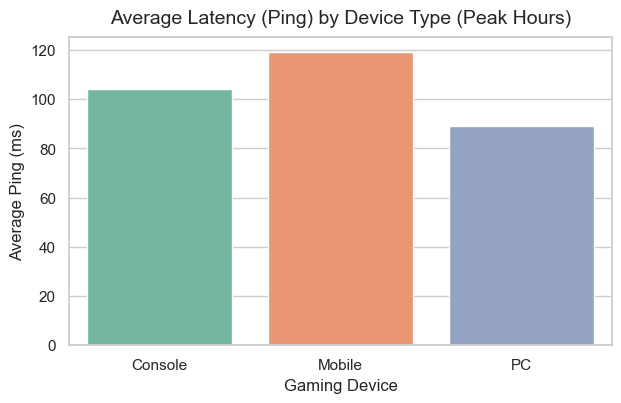

In [7]:
# --- PHASE 4: HARDWARE COMPARISON CODE ---
print("Comparing network stability across different gaming devices...")

# Group by device and calculate mean metrics during peak hours
device_comparison = peak_hours_df.groupby('Device_Type').agg({
    'Ping_ms': 'mean',
    'Packet_Loss_Percentage': 'mean'
}).round(2).reset_index()

# Display the findings cleanly
print("\nPeak Hour Device Performance Summary:")
print(device_comparison.to_string(index=False))

# Quick visualization of the packet loss difference
# Quick visualization of the LATENCY difference
plt.figure(figsize=(7, 4))
# Updated to avoid the FutureWarning here too!
sns.barplot(data=device_comparison, x='Device_Type', y='Ping_ms', hue='Device_Type', palette='Set2', legend=False)
plt.title('Average Latency (Ping) by Device Type (Peak Hours)', fontsize=14, pad=10)
plt.ylabel('Average Ping (ms)')
plt.xlabel('Gaming Device')
plt.show()